In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_dir = 'data' #data from polybox (ASV, taxonomy analysis)
or_dir = '../data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [2]:
! wget -nv -O $data_dir/taxonomy_classification.qzv 'https://polybox.ethz.ch/index.php/s/c3rjz7z9GBUXvE8/download'
! wget -nv -O $data_dir/taxonomy_classification.qza 'https://polybox.ethz.ch/index.php/s/X8AoIryeOnLaCn5/download'
! wget -nv -O $data_dir/PJNB_dada2_table-filtered.qza 'https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download'
! wget -nv -O $data_dir/PJNB_dada2_rep_set-filtered.qza 'https://polybox.ethz.ch/index.php/s/vtDJzaCrmebL2u7/download'

2022-11-15 17:48:55 URL:https://polybox.ethz.ch/index.php/s/c3rjz7z9GBUXvE8/download [1967910/1967910] -> "data/taxonomy_classification.qzv" [1]
2022-11-15 17:48:55 URL:https://polybox.ethz.ch/index.php/s/X8AoIryeOnLaCn5/download [397957/397957] -> "data/taxonomy_classification.qza" [1]
2022-11-15 17:48:56 URL:https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download [1818719/1818719] -> "data/PJNB_dada2_table-filtered.qza" [1]
2022-11-15 17:48:56 URL:https://polybox.ethz.ch/index.php/s/vtDJzaCrmebL2u7/download [552613/552613] -> "data/PJNB_dada2_rep_set-filtered.qza" [1]


In [2]:
metadata = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')

In [3]:
print(metadata.shape)
print(metadata['host_id'].nunique()) # number of hosts that were followed over time

(1669, 26)
80


In [4]:
taxonomic_assignments = pd.read_csv(data_dir+'/taxonomic_assignments.csv', index_col = 0) # import metadata with taxonomic assignment dataframe
#print(taxonomic_assignments.head())
print(taxonomic_assignments['diet_weaning'].unique())
print(taxonomic_assignments['diet_milk'].unique())

[nan True False]
[nan 'bd' 'fd' 'no milk']


In [10]:
col_names = taxonomic_assignments.columns
print(col_names[-25:])
col_names_species = col_names[0:-25] #remove metadata columns, get all species
print(len(col_names_species), 'total number of taxonomies, all depths')
col_names_species = [i for i in col_names_species if not i.endswith('__')] #remove taxonomies unclassfied until species
print(len(col_names_species), 'species were identified in total')

Index(['Library Layout', 'Instrument', 'collection_date', 'geo_location_name',
       'geo_latitude', 'geo_longitude', 'host_id', 'age_days', 'weight_kg',
       'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI', 'birth_weight_g',
       'birth_length_cm', 'sex', 'delivery_mode', 'zygosity', 'race',
       'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')
339 total number of taxonomies, all depths
140 species were identified in total


## Strings for diet, no Booleans, no NaN

In [11]:
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].replace({True: 'weaning', False:'not weaning'})
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].fillna('weaned')
taxonomic_assignments['diet_milk'] = taxonomic_assignments['diet_milk'].fillna('weaned')
print(taxonomic_assignments['diet_weaning'].unique())
print(taxonomic_assignments['diet_milk'].unique())

['weaned' 'weaning' 'not weaning']
['weaned' 'bd' 'fd' 'no milk']


## Questions about data
A. Do all hosts go through weaning? 
    A: Yes
B. How many hosts switch back and forth 1 or more times between weaning True/False or NaN?
    B: 
C. What is the distribution of diets?
    A: See bar plot

In [21]:
###A.
host_numbers = taxonomic_assignments['host_id'].unique()
for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host]
    if (df['diet_weaning'] == 'weaning').sum() == 0:
        print(host, 'did not wean')

In [53]:
###B.
a=0
def collapse_consec_values(series): # function to collapse consecutive identical values into 1 
    # e.g. ['not weaning', 'weaning', 'weaning', 'weaning', 'weaned', 'weaning']
    # into ['not weaning', 'weaning', 'weaned', 'weaning']
    series = list(series)
    new = []
    new.append(series[0])
    for i in range(1, len(series)):
        if series[i] != series[i-1]:
            new.append(series[i])
    return new

total_switch_weaning=0
number_switch_weaning=0
total_switch_milk=0 # fact that the host switched between modes at least once or not
number_switch_milk=0 # number of extra switches in each host, summed

for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age
    weanings = collapse_consec_values(df['diet_weaning'])
    if weanings != ['not weaning', 'weaning', 'weaned']:
        b=1
        print(weanings)
        print(host)
    if len(np.unique(np.array(weanings))) < len(weanings):
        total_switch_weaning = total_switch_weaning + 1
        number_switch_weaning = number_switch_weaning + len(weanings) - len(np.unique(np.array(weanings)))
    milk = collapse_consec_values(df['diet_milk'])
    if len(np.unique(np.array(milk))) < len(milk):
        total_switch_milk = total_switch_milk + 1
        number_switch_milk = number_switch_milk+ len(milk) - len(np.unique(np.array(milk)))
    #print(milk)
    if len(ages.unique()) < len(ages):
        print(host)
        a=a+1
print(a, ' repeat measurements for one age (days)')
print(total_switch_weaning, ' number of hosts that switch back and forth between weaning and/or not weaning and/or NaN')
print(total_switch_milk, ' number of hosts that switch back and forth between breast milk and/or formula and/or no milk and/or NaN')
print(number_switch_weaning, ' number of times a weaning mode is repeated (not taking into account consecutive instances, they count as one)')
print(number_switch_milk, ' number of times a milk feeding mode is repeated (not taking into account consecutive instances, they count as one)')

['weaning', 'weaned']
10.1
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
14.1
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
14.2
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
15.1
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
15.2
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
16.1
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
16.2
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
17.1
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
17.2
['weaning', 'weaned']
19.1
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
2.1
['weaning', 'weaned', 'weaning']
11.1
['weaning']
11.2
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
23.1
['not weaning', 'weaning']
26.1
['not weaning', 'weaning']
26.2
['weaning', 'weaned']
29.1
['not weaning', 'weaned', 'weaning', 'weaned']
36.1
['not weaning', 'weaned', 'weaning', 'weaned']
36.2
['not weaning', 

<AxesSubplot:>

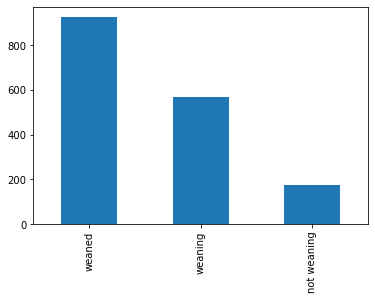

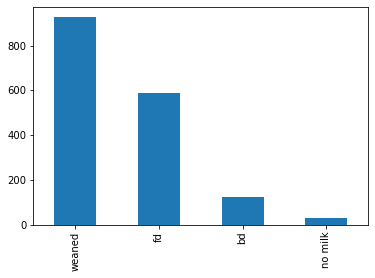

In [13]:
###C.
plt.figure()
taxonomic_assignments['diet_weaning'].value_counts().plot(kind='bar')
plt.figure()
taxonomic_assignments['diet_milk'].value_counts().plot(kind='bar')

## Decision tree classifier for milk diet and for weaning

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

def DTC(target, predictor):
    clf = DecisionTreeClassifier(random_state=0, max_depth = 50, min_samples_split = 0.01)
    #target = taxonomic_assignments['diet_milk'].fillna('weaned')
    cv_clf_milk = cross_val_score(clf, predictor, target, cv=10)
    print(sum(cv_clf_milk)/len(cv_clf_milk))

In [22]:
DTC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments[col_names_species])
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

0.7303549527451122
0.6920027415049419


In [38]:
taxonomic_assignments[col_names_species].isnull().sum().sum()

0

## Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

def RFC(target, predictor):
    rfc = RandomForestClassifier(random_state=0)#, max_depth = 50, min_samples_split = 0.01)
    #target = taxonomic_assignments['diet_milk'].fillna('weaned')
    cv_rfc_milk = cross_val_score(rfc, predictor, target, cv=10)
    print(sum(cv_rfc_milk)/len(cv_rfc_milk))

In [24]:
RFC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments[col_names_species])
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

0.8388247601183177
0.8130473991775485


## Ideas
* transform counts to fractions
* ASV instead of taxonomic assignment
* classifier: k-means, GMM (even though not Gaussian :/), Bayes, SVM
* Dimensionality reduction: either PCA or one of those or use decision tree to get most important features/species for this classification task
* try different taxonomic levels (now have only species)
* could select features with decision tree and then build NN classifier
* Which classes are being missclassified by these models?

## Repeat analysis using fractions of abundance per species

In [18]:
taxonomic_assignments_frac = taxonomic_assignments[col_names_species].div(taxonomic_assignments[col_names_species].sum(axis=1), axis=0)

In [26]:
DTC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_frac)
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

RFC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_frac)
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

0.7369453863357622
0.7255609263400908
0.8316391313758027
0.8136389870860687


In [19]:
taxonomic_assignments_frac

,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__variabile,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus;s__lactaris,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__[Ruminococcus];s__gnavus,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__mucilaginosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__prausnitzii,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__neonatale,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Gemmiger;s__formicilis,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__macerans,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__islandicum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__eutactus,...,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium;s__vaginae,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoanaerobaculum;s__orale,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Anaerorhabdus;s__furcosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Selenomonas;s__noxia,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__ureolyticus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__agalactiae,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__europaeus,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Bulleidia;s__moorei,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__methylpentosum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__septicum
index,,,,,,,,,,,,,,,,,,,,,
ERR1309715,0.0,0.006466,0.036298,0.000000,0.400862,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309716,0.0,0.016798,0.456588,0.000000,0.197126,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309717,0.0,0.000000,0.300750,0.000000,0.300500,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309718,0.0,0.000000,0.198964,0.000000,0.389701,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309719,0.0,0.005904,0.022502,0.000000,0.314025,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1315696,0.0,0.000000,0.117509,0.000000,0.587740,0.000000,0.007834,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1315697,0.0,0.000000,0.185819,0.000326,0.000000,0.003097,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002771,0.0,0.0,0.0
ERR1331873,0.0,0.000000,0.000000,0.000000,0.000000,0.034865,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## PCA + standardize

In [35]:
from sklearn.preprocessing import StandardScaler
taxonomic_assignments_normal = pd.DataFrame(StandardScaler().fit_transform(taxonomic_assignments[col_names_species]))
taxonomic_assignments_normal.columns = taxonomic_assignments[col_names_species].columns
taxonomic_assignments_normal.set_index(taxonomic_assignments[col_names_species].index, inplace = True)

In [36]:
taxonomic_assignments_normal

,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__variabile,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus;s__lactaris,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__[Ruminococcus];s__gnavus,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__mucilaginosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__prausnitzii,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__neonatale,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Gemmiger;s__formicilis,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__macerans,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__islandicum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__eutactus,...,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium;s__vaginae,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoanaerobaculum;s__orale,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Anaerorhabdus;s__furcosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Selenomonas;s__noxia,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__ureolyticus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__agalactiae,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__europaeus,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Bulleidia;s__moorei,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__methylpentosum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__septicum
index,,,,,,,,,,,,,,,,,,,,,
ERR1309715,-0.144532,0.534559,-0.452721,-0.211927,1.416353,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1309716,-0.144532,0.913905,0.625450,-0.211927,-0.223863,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1309717,-0.144532,-0.297085,0.039027,-0.211927,-0.077782,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1309718,-0.144532,-0.297085,0.096389,-0.211927,0.791020,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1309719,-0.144532,0.476198,-0.518436,-0.211927,0.958246,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1315696,-0.144532,-0.297085,-0.296787,-0.211927,1.074855,-0.198385,-0.147784,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1315697,-0.144532,-0.297085,0.003942,0.392698,-0.847914,-0.134881,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,8.734702,-0.08633,-0.065374,-0.065275
ERR1331873,-0.144532,-0.297085,-0.630931,-0.211927,-0.847914,0.169267,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275


In [123]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(taxonomic_assignments_normal)
principalComponents = pd.DataFrame(principalComponents)
principalComponents.set_index(taxonomic_assignments[col_names_species].index, inplace = True)

principalComponents_nonnormal = pca.fit_transform(taxonomic_assignments[col_names_species])
principalComponents_nonnormal = pd.DataFrame(principalComponents_nonnormal)
principalComponents_nonnormal.set_index(taxonomic_assignments[col_names_species].index, inplace = True)

principalComponents.describe()
principalComponents.head()

,0,1
index,,
ERR1309715,-0.690652,-0.038959
ERR1309716,-0.161088,-0.031513
ERR1309717,0.352888,-0.015570
ERR1309718,0.015083,0.038470
ERR1309719,-0.778224,0.089948


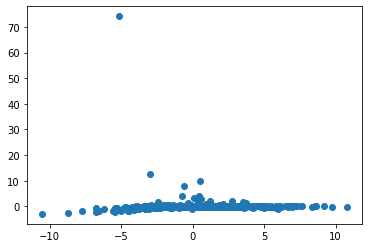

In [124]:
#plt.scatter(np.log(principalComponents.iloc[:,0]), np.log(principalComponents.iloc[:,1]))
plt.scatter(principalComponents.iloc[:,0], principalComponents.iloc[:,1])

{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}
weaning
1669
not weaning
1669
weaned
1669


(-5.0, 15.0)

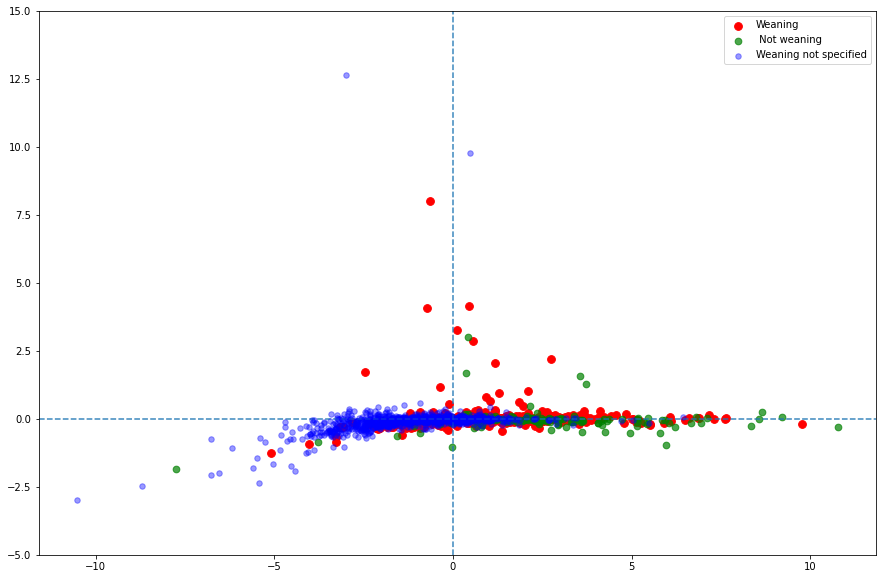

In [127]:
colours_weaning = {'weaning':'red', 'not weaning':'green', 'weaned':'blue'}#, 'other':'black'}
print(colours_weaning)
labels = ['Weaning', ' Not weaning', 'Weaning not specified']
fig, ax = plt.subplots(figsize = (15,10))
i=0
for key in colours_weaning:
    indices = (taxonomic_assignments['diet_weaning'] == key)
    print(key)
    print(len(indices))
    PCAs = principalComponents.loc[indices, ]
    ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
               color = colours_weaning[key], label = labels[i], s = 60-i*15,
               zorder = i, alpha = 1-i*0.3)
    ax.axhline(0, linestyle = '--', alpha = 0.4)
    ax.axvline(0, linestyle = '--', alpha = 0.4)
    i=i+1
ax.legend()
ax.set_ylim([-5, 15]) #one outlier at 70

(-5.0, 15.0)

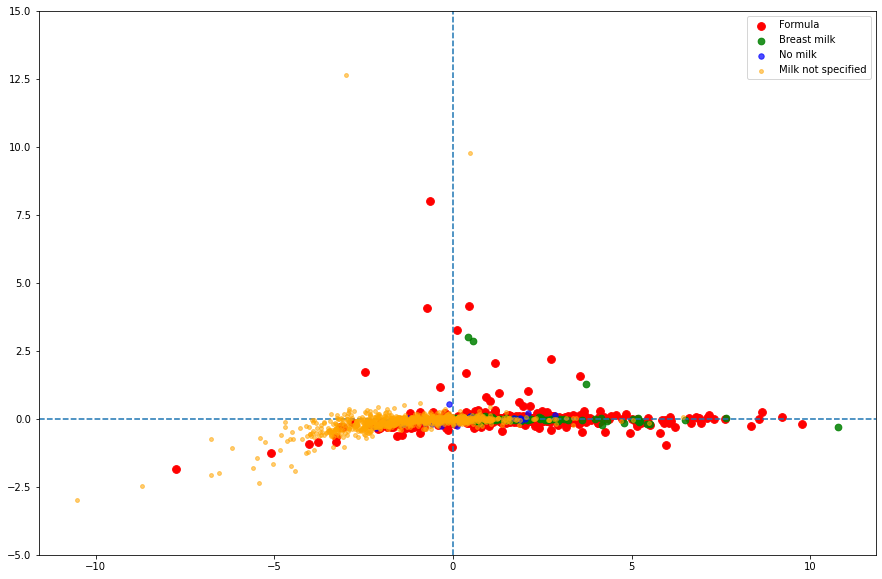

In [129]:
color_formula_breast = {'fd': 'red', 'bd': 'green', 'no milk': 'blue', 'weaned': 'orange'}
labels = ['Formula', 'Breast milk', 'No milk', 'Milk not specified']

fig, ax = plt.subplots(figsize = (15,10))
i=0
for key in color_formula_breast:
    indices = (taxonomic_assignments['diet_milk'] == key)
    PCAs = principalComponents.loc[indices, ]
    ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
               color = color_formula_breast[key], label = labels[i], s = 60-i*15,
                zorder = i, alpha = 1-i*0.15)
    ax.axhline(0, linestyle = '--', alpha = 0.4)
    ax.axvline(0, linestyle = '--', alpha = 0.4)
    i=i+1
ax.legend()
ax.set_ylim([-5, 15]) #one outlier at 70

In [110]:
(taxonomic_assignments['diet_weaning'] == key).sum()

1669